In [222]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math
from pathlib import Path

from fastai.dataset import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.structured import *

import pdb

import pickle
from sklearn.model_selection import train_test_split

from IPython.display import FileLink
% load_ext autoreload
% autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"
rsna_path = Path(ddir)

detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [3]:
rsna_merged_labels = '../tmp/rsna_merged_labels.csv'
merged_csv = pd.read_csv(rsna_merged_labels); merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0,562.0 152.0 818.0 605.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0,323.0 577.0 483.0 681.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0,695.0 575.0 857.0 712.0


In [25]:
merged_csv['bbox_corners'] = merged_csv['bbox_corners'].map(lambda x: '0 0 0 0' if (x == '' ) else x)

In [26]:
merged_csv[:5]

,patientId,x,y,width,height,Target,class,codes,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0,264.0 152.0 477.0 531.0


In [27]:
merged_csv.to_csv(rsna_merged_labels, index=False)

In [28]:
sample_csv = merged_csv.sample(n=1000)

In [88]:
sample_csv[['patientId','bbox_corners']].to_csv('../tmp/sample_with_bbox_corners.csv', index=False)
sample_csv[['patientId','Target']].to_csv('../tmp/sample_with_target.csv', index=False)

In [89]:
SAMPLE_LABELS_BBOX_FN = '../tmp/sample_with_bbox_corners.csv'
SAMPLE_LABELS_TARGET_FN = '../tmp/sample_with_target.csv'

In [31]:
(Path('../tmp')/'sample_with_bbox_corners.csv').open().readlines()[:5]

['patientId,bbox_corners\n',
 '47ba820c-c63e-4efa-90af-7b88e6741151,546.0 197.0 804.0 636.0\n',
 '4c84cff2-475b-46e9-8fc6-68ce72f9274b,0 0 0 0\n',
 '85682fd3-9d19-4b37-a663-6071cbfb82af,602.0 305.0 935.0 885.0\n',
 'cbfc0e6b-be9f-42a0-be31-201692df68cf,0 0 0 0\n']

In [90]:
(Path(SAMPLE_LABELS_TARGET_FN)).open().readlines()[:5]

['patientId,Target\n',
 '47ba820c-c63e-4efa-90af-7b88e6741151,1\n',
 '4c84cff2-475b-46e9-8fc6-68ce72f9274b,0\n',
 '85682fd3-9d19-4b37-a663-6071cbfb82af,1\n',
 'cbfc0e6b-be9f-42a0-be31-201692df68cf,0\n']

In [32]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)

In [33]:
md = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_BBOX_FN, bs=64, 
                                   tfms=tfms, suffix='.dcm', continuous=True)

In [35]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)

In [52]:
learn.lr_find(1e-10, 1e-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      35.296136  71.994204 



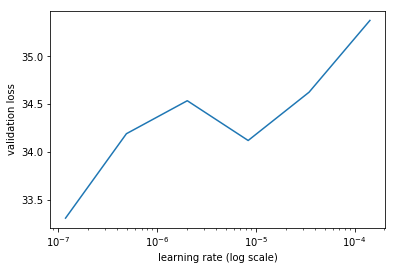

In [53]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [51]:
?? learn.sched.plot

In [54]:
learn.fit(1e-3, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      35.480286  31.481071 
    1      35.197469  31.05524                            



[31.055240173339843]

In [55]:
learn.freeze_to(-2)

In [56]:
learn.fit(1e-3, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      33.16511   26.951529 
    1      28.085395  25.725522                           



[25.725522003173829]

In [57]:
learn.fit(1e-3, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      18.273931  24.949706 
    1      16.109934  24.954261                           
    2      14.406946  23.92405                            
    3      13.140692  25.253292                           



[25.253292083740234]

In [58]:
lrs = np.array([1e-4,1e-2,1e-1])

In [59]:
learn.lr_find(lrs)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      292.512043 2.27193910861e+15



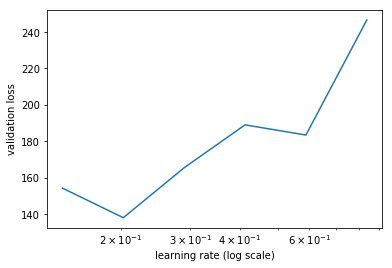

In [60]:
learn.sched.plot(1)

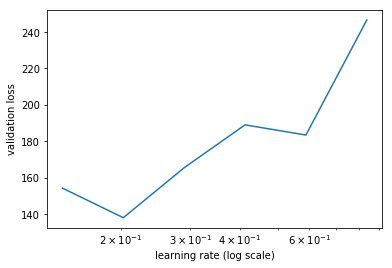

In [64]:
learn.sched.plot(1)

In [65]:
lr = 2e-1

In [66]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      82.43136   17416179.84
    1      57.183099  722.236721                          
    2      47.799008  409.75019                           
    3      42.606463  38.90781                            



[38.907810211181641]

In [67]:
learn.unfreeze()

In [68]:
learn.save('../tmp/rsna_5.pth')

In [69]:
learn.model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [71]:
learn.model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [75]:
x, y = next(iter(md.trn_dl))

In [76]:
preds = to_np(predict_batch(learn.model, x)); preds[:10], y[:10]

(array([[  -0.05403,    0.05781,   -0.05314,    0.20144],
        [   7.17969,    3.92191,    4.39247,   10.97632],
        [  43.88998,   57.0424 ,   57.66828,  115.54762],
        [   0.06112,   -0.05996,   -0.00794,    0.27169],
        [  -0.05403,    0.05781,   -0.05314,    0.20144],
        [   1.47962,    0.77771,    1.27265,    3.2331 ],
        [  -0.05403,    0.05781,   -0.05314,    0.20144],
        [  72.55693,   83.13942,   90.95323,  150.16846],
        [   0.52242,   -0.26477,    0.51186,    1.63082],
        [   1.02807,    0.40753,    0.16863,    1.92346]], dtype=float32),
 tensor([[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [  46.,   59.,   89.,  141.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [ 130.,   91.,  172.,  142.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]], device='cuda

In [79]:
sample_res = np.clip(preds[:10], 0, 1000); sample_res

array([[   0.     ,    0.05781,    0.     ,    0.20144],
       [   7.17969,    3.92191,    4.39247,   10.97632],
       [  43.88998,   57.0424 ,   57.66828,  115.54762],
       [   0.06112,    0.     ,    0.     ,    0.27169],
       [   0.     ,    0.05781,    0.     ,    0.20144],
       [   1.47962,    0.77771,    1.27265,    3.2331 ],
       [   0.     ,    0.05781,    0.     ,    0.20144],
       [  72.55693,   83.13942,   90.95323,  150.16846],
       [   0.52242,    0.     ,    0.51186,    1.63082],
       [   1.02807,    0.40753,    0.16863,    1.92346]], dtype=float32)

In [86]:
sample_res[sample_res < 10] = 0

In [87]:
sample_res

array([[   0.     ,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,    0.     ,   10.97632],
       [  43.88998,   57.0424 ,   57.66828,  115.54762],
       [   0.     ,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,    0.     ,    0.     ],
       [  72.55693,   83.13942,   90.95323,  150.16846],
       [   0.     ,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,    0.     ,    0.     ]], dtype=float32)

In [98]:
md = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_BBOX_FN, bs=64, 
                                   tfms=tfms, suffix='.dcm', continuous=True, test_name='test2')
md2 = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_TARGET_FN, bs=64, 
                                   tfms=tfms_from_model(f_model, sz), suffix='.dcm', test_name='test2' )

In [99]:
len(md.test_ds)

1000

In [103]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds = ds
        self.y2 = y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [104]:
trn_ds_2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds_2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [108]:
md.trn_dl.dataset = trn_ds_2
md.val_dl.dataset = val_ds_2

In [109]:
x, y = next(iter(md.trn_dl))

In [167]:
custom_head = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4+2)
)

models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=custom_head)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [168]:
learn.crit = nn.L1Loss()

In [169]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [170]:
def detn_loss(input, target):
    bb_t, c_t = target
    bb_i, c_i = input[:, :4], input[:,4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t, _ = target
    bb_i = input[:,:4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i), V(bb_t)).data

def detn_acc(input, target):
    _, c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)


In [171]:
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [172]:
learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      3325.495411 1993347.795 0.48       118.10625 



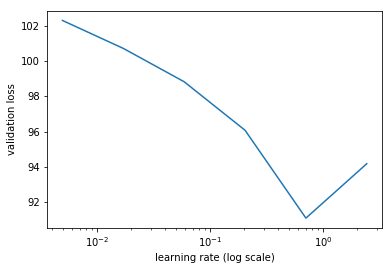

In [174]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [175]:
lr = 1e-2

In [178]:
learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.43974   42.835684  0.795      24.87041  
    1      16.361413  43.342636  0.8        24.819881     



[43.342636489868163, 0.80000000000000004, 24.819880676269531]

In [179]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      14.086503  44.424874  0.795      24.813926 
    1      13.576858  44.56763   0.8        23.966265     
    2      13.192656  44.70381   0.8        24.025264     



[44.703809967041018, 0.80000000000000004, 24.025263900756837]

In [181]:
learn.save('../tmp/rsna_5.pth')

In [182]:
learn.freeze_to(-2)

In [183]:
lrs = np.array([lr/100, lr/10, lr])

In [184]:
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      100.989753 6.08691148545e+22 0.745      29.11625  



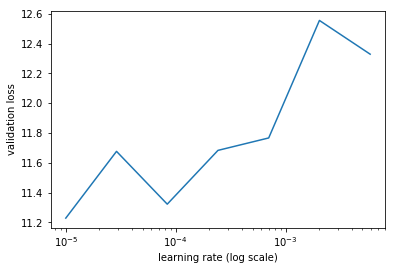

In [185]:
learn.sched.plot(0)

In [186]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.021125  61.093571  0.765      30.205763 
    1      20.396989  61.236611  0.74       28.797272     
    2      18.383412  50.94416   0.825      23.407654     
    3      16.601992  42.118989  0.82       23.893709     
    4      14.608539  40.961492  0.815      24.053549     



[40.961491928100585, 0.81499999999999995, 24.053549194335936]

In [187]:
learn.save('../tmp/rsna_5.pth')

In [188]:
learn.unfreeze()

In [189]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      14.943598  48.281407  0.78       26.460513 
    1      14.503122  50.437133  0.79       28.769412     
    2      14.386667  43.937407  0.8        23.919224     
    3      13.375852  45.683578  0.795      24.935836     
    4      12.609202  44.714429  0.84       23.56125      
    5      11.686097  44.256889  0.845      23.283142     
    6      11.208489  43.70459   0.835      23.661895     
    7      10.790642  43.123127  0.83       23.201296     
    8      10.197489  42.816747  0.835      23.337748     
    9      9.911062   42.622013  0.83       23.069789     



[42.622013397216797, 0.82999999999999996, 23.069788818359374]

In [191]:
from scipy.special import expit

In [192]:
expit(y_preds[5][:4] * 224)

array([ 0.,  0.,  0.,  0.], dtype=float32)

In [193]:
c = np.argmax(y_preds[1][4:]); c

1

In [194]:
def bb_hw(bb):
    x = bb[0]
    y = bb[1]
    w = bb[2] - bb[0]
    h = bb[3] - bb[1]
    return np.array([x, y, w, h])

In [201]:
x, y, w, h = bb_hw(expit(y_preds[8][:4] * 224))
c = np.argmax(y_preds[1][4:])

In [204]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [270]:
def draw_rect(ax, bb, color='red'):
    x, y, width, height = bb
    rect = Rectangle((x,y), width, height, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

In [236]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [237]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [225]:
learn.save('../tmp/rsna_5.pth')

In [245]:
len(sample_csv[sample_csv['Target'] == 1])

297

In [246]:
test_preds = learn.predict(is_test=True)

In [286]:
x, y = next(iter(md.val_dl))
y_preds = to_np(predict_batch(learn.model, x));y[0][:10], y[1][:10], y_preds[:10]

(tensor([[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [ 123.,   42.,  173.,  136.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0], device='cuda:0'),
 array([[-6.46482, -6.05639, -6.52114, -6.2264 ,  7.54106, -7.14906],
        [-0.85032, -1.32045,  0.10909,  0.14699, -3.34397,  3.28321],
        [-1.75704, -2.19862, -1.16551, -1.1284 , -0.88022,  0.99817],
        [-0.3099 , -1.2224 ,  0.9232 ,  0.71827, -5.52673,  5.41367],
        [-4.99202, -4.46907, -4.98405, -4.58894,  4.50093, -4.2445 ],
        [-1.60899, -2.02314, -0.87444, -1.00723, -1.5488 ,  1.53596],
        [-7.30765, -6.79895, -7.59703, -7.07903,  8.72235, -8.19026],
        [-6.9856 , -6.53037, -7.0

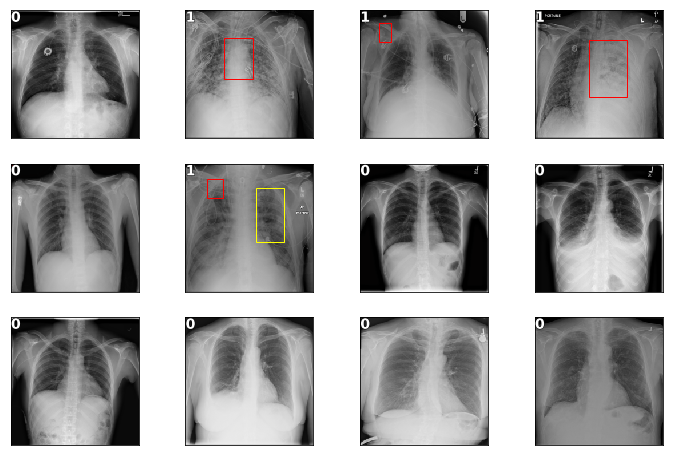

In [287]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[i]
    bb = bb_hw(expit(y_preds[i][:4])*224)
    y_bb = bb_hw(y[0][i])
    c = np.argmax(y_preds[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, bb)
    draw_rect(ax, y_bb, 'yellow')
    draw_text(ax, (0,0), c)

In [247]:
len(test_preds)

1000

In [250]:
test_preds[:10]

array([[ -0.64398,  -1.11363,   0.3248 ,   0.26526,  -3.79437,   3.82414],
       [ -6.99281,  -6.5414 ,  -7.11564,  -6.66515,   8.12737,  -7.72688],
       [ -8.66899,  -7.99387,  -8.96523,  -8.51066,  11.18702, -10.65794],
       [ -8.01051,  -7.29575,  -8.36727,  -7.82811,  10.34445,  -9.78548],
       [ -8.87214,  -7.47252,  -9.41979,  -8.48165,  11.5375 , -11.00835],
       [ -6.54331,  -6.14677,  -6.52769,  -6.10066,   7.02171,  -6.60799],
       [ -5.19805,  -4.99754,  -5.04696,  -4.93681,   5.46337,  -5.20778],
       [ -6.41064,  -6.22525,  -6.52754,  -6.279  ,   7.2741 ,  -6.91782],
       [ -7.14376,  -6.18991,  -7.44049,  -7.23628,   9.04105,  -8.67582],
       [ -1.50291,  -1.84751,  -0.81591,  -0.87503,  -1.17279,   1.2205 ]], dtype=float32)

In [254]:
results = list(zip(md.test_ds.fnames, test_preds))

In [321]:
bbox[:10]

[array([ 352.61224,  253.12715,  241.81335,  326.38477], dtype=float32),
 array([ 0.93964,  1.47495, -0.10851, -0.17146], dtype=float32),
 array([ 0.17593,  0.34551, -0.0451 , -0.13941], dtype=float32),
 array([ 0.33981,  0.69423, -0.10194, -0.28645], dtype=float32),
 array([ 0.14359,  0.58181, -0.06055, -0.36964], dtype=float32),
 array([ 1.47216,  2.18708,  0.02314,  0.10297], dtype=float32),
 array([ 5.62886,  6.87022,  0.91223,  0.42714], dtype=float32),
 array([ 1.68066,  2.02232, -0.18515, -0.10563], dtype=float32),
 array([ 0.80809,  2.09492, -0.20736, -1.35818], dtype=float32),
 array([ 186.35954,  139.43291,  127.63213,  161.83714], dtype=float32)]

In [322]:
test_names = list(map(lambda x: x.split('/')[1].split('.dcm')[0], md.test_ds.fnames))
bbox = list(map( lambda x: bb_hw(expit(x[:4]) * 1024), test_preds))
c_s = list(map(lambda x: np.argmax(x[4:]), test_preds))

In [323]:
def prediction_string(row):
    if row['target'] == 1:
        x, y, width, height = row["bbox"]
        return f"1.0 {x} {y} {width} {height}"
    else:
        return ""

In [324]:
df_test = pd.DataFrame(list(zip(test_names, bbox, c_s)), columns=['patientId', 'bbox', 'target'])

In [325]:
df_test['PredictionString'] = df_test.apply(prediction_string, axis=1)

In [326]:
df_test[['patientId', 'PredictionString']].to_csv('../tmp/test_results.csv', index=False)
FileLink('../tmp/test_results.csv')

/home/edwin/Developer/kaggle-comps/tmp/test_results.csv